✅ File found: D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\0_61938.csv
Created 61928 sequences of shape (10, 4)
1936/1936 [==============================] - 3s 1ms/step
✅ Features extracted: (61928, 32)


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


✅ Labels: (array(['Buy', 'Hold', 'Sell'], dtype='<U4'), array([20676, 25233, 16019], dtype=int64))
Epoch 1/20
1549/1549 [==============================] - 7s 3ms/step - loss: 0.0483 - accuracy: 0.9803 - val_loss: 0.0447 - val_accuracy: 0.9876
Epoch 2/20
1549/1549 [==============================] - 5s 4ms/step - loss: 0.0219 - accuracy: 0.9913 - val_loss: 0.1461 - val_accuracy: 0.9400
Epoch 3/20
1549/1549 [==============================] - 5s 3ms/step - loss: 0.0169 - accuracy: 0.9929 - val_loss: 0.0276 - val_accuracy: 0.9885
Epoch 4/20
1549/1549 [==============================] - 5s 3ms/step - loss: 0.0140 - accuracy: 0.9942 - val_loss: 0.0216 - val_accuracy: 0.9895
Epoch 5/20
1549/1549 [==============================] - 5s 3ms/step - loss: 0.0115 - accuracy: 0.9951 - val_loss: 0.0133 - val_accuracy: 0.9970
Epoch 6/20
1549/1549 [==============================] - 5s 3ms/step - loss: 0.0109 - accuracy: 0.9953 - val_loss: 0.0158 - val_accuracy: 0.9922
Epoch 7/20
1549/1549 [===============

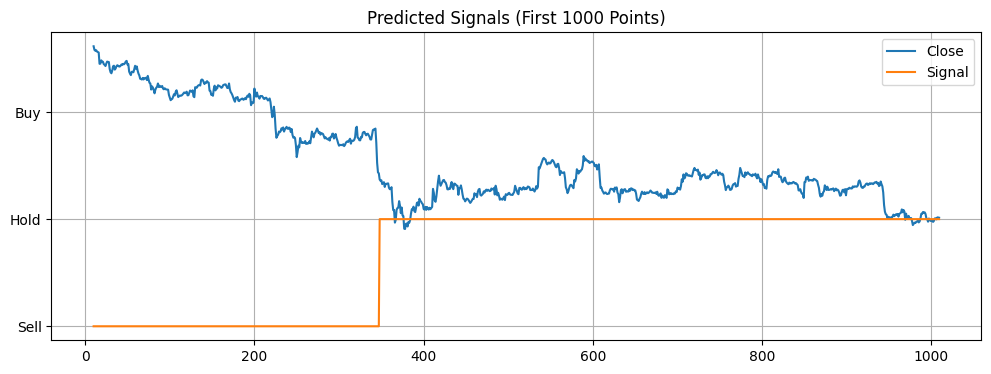

In [40]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import matplotlib.pyplot as plt
import os

# -------------------------------
# 1️⃣ Configuration and Data Load
# -------------------------------
epoch_num = 5
sequence_length = 10
file_name = '0_61938.csv'
data_dir = 'ohlc_data'
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_path = os.path.join(base_dir, data_dir, file_name)

if os.path.exists(data_path):
    print(f"✅ File found: {data_path}")
else:
    raise FileNotFoundError(f"❌ File not found at {data_path}")

df = pd.read_csv(data_path, usecols=['Open', 'High', 'Low', 'Close'])
scaler = StandardScaler()
df[['Open', 'High', 'Low', 'Close']] = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close']])

# -------------------------------
# 2️⃣ Create Sliding Windows
# -------------------------------
def create_ohlc_windows(df, window_size=10):
    X = []
    for i in range(len(df) - window_size):
        X.append(df[['Open', 'High', 'Low', 'Close']].iloc[i:i+window_size].values)
    return np.array(X)

X = create_ohlc_windows(df, sequence_length)
print(f"Created {X.shape[0]} sequences of shape {X.shape[1:]}")

# -------------------------------
# 3️⃣ Feature Extraction via LSTM Encoder
# -------------------------------
def create_encoder(input_shape):
    inp = Input(shape=input_shape)
    x = LSTM(64, return_sequences=False)(inp)
    x = Dense(32, activation='relu')(x)
    return Model(inp, x)

encoder = create_encoder((X.shape[1], X.shape[2]))
features = encoder.predict(X)
print("✅ Features extracted:", features.shape)

# -------------------------------
# 4️⃣ Unsupervised Clustering (KMeans)
# -------------------------------
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features)

# compute returns for mapping clusters
returns = (df["Close"].shift(-1) - df["Close"]) / df["Close"]
returns = returns.iloc[sequence_length:].values[:len(cluster_labels)]

# -------------------------------
# 5️⃣ Map Clusters → Buy/Sell/Hold
# -------------------------------
cluster_return_map = {i: np.mean(returns[cluster_labels == i]) for i in range(num_clusters)}
sorted_clusters = sorted(cluster_return_map, key=cluster_return_map.get)
cluster_to_label = {
    sorted_clusters[0]: "Sell",
    sorted_clusters[1]: "Hold",
    sorted_clusters[2]: "Buy"
}

labels = np.vectorize(cluster_to_label.get)(cluster_labels)
le = LabelEncoder()
y = le.fit_transform(labels)
print("✅ Labels:", np.unique(labels, return_counts=True))

# -------------------------------
# 6️⃣ Train/Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # sequential data: no random shuffle
)

# -------------------------------
# 7️⃣ Train Final Classifier
# -------------------------------
x = Dense(num_clusters, activation='softmax')(encoder.output)
final_model = Model(inputs=encoder.input, outputs=x)
final_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = final_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# -------------------------------
# 8️⃣ Evaluate and Visualize
# -------------------------------
test_loss, test_acc = final_model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {test_acc:.3f}")

predictions = final_model.predict(X)
predicted_labels = np.argmax(predictions, axis=1)
predicted_signals = le.inverse_transform(predicted_labels)

df_signals = df.iloc[sequence_length:].copy()
df_signals["Signal"] = predicted_signals

signal_map = {"Sell": -1, "Hold": 0, "Buy": 1}
numeric_signals = df_signals["Signal"].map(signal_map)

plt.figure(figsize=(12, 4))
df_signals["Close"].iloc[:1000].plot(label="Close")
numeric_signals.iloc[:1000].plot(label="Signal")
plt.yticks([-1, 0, 1], ["Sell", "Hold", "Buy"])
plt.title("Predicted Signals (First 1000 Points)")
plt.legend()
plt.grid(True)
plt.show()


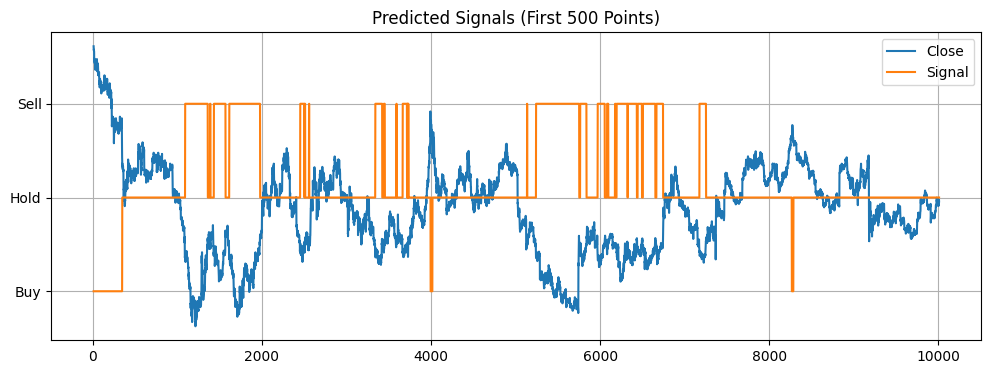

In [43]:
plt.figure(figsize=(12, 4))
df_signals["Close"].iloc[:10000].plot(label="Close")
numeric_signals.iloc[:10000].plot(label="Signal")
plt.yticks([-1, 0, 1], ["Sell", "Hold", "Buy"])
plt.title("Predicted Signals (First 500 Points)")
plt.legend()
plt.grid(True)
plt.show()
